In [1]:
!pip install -qq transformers[sentencepiece]
!pip install -qq ohmeow-blurr
!pip install  -qq fastai --upgrade
!pip install -qq datasets
!pip install evaluate

^C


# IMPORT

In [2]:
import ast, inspect, torch
from typing import Any, Callable, Dict, List, Optional, Union, Type

from evaluate import load as hf_load_metric
from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, ranger, OptimWrapper, params
from fastai.torch_core import *
from fastai.torch_imports import *
from fastai.text.all import *
from fastprogress.fastprogress import progress_bar,master_bar
from transformers import (
    AutoModelForSeq2SeqLM, logging,
    PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel
)

from blurr.utils import BLURR
from blurr.data.seq2seq.core import HF_Seq2SeqBlock, HF_Seq2SeqBeforeBatchTransform, default_text_gen_kwargs
from blurr.modeling.core import HF_BaseModelWrapper, HF_BaseModelCallback, HF_PreCalculatedLoss, Blearner
from blurr.modeling.seq2seq.core import HF_Seq2SeqMetricsCallback, seq2seq_splitter

logging.set_verbosity_error()

In [3]:
import os, ast, inspect, pdb
from functools import reduce

from datasets import load_dataset
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from transformers import MBartForConditionalGeneration

from blurr.utils import print_versions

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print_versions('torch fastai transformers')

torch: 2.5.1+cu121
fastai: 2.7.18
transformers: 4.49.0


# DATASET

In [4]:
def listPaths(path):
  pathfiles = list()
  for pathfile in glob.glob(path):
    pathfiles.append(pathfile)
  return pathfiles

train_paths = listPaths('D:/vietnews/data/train_tokenized/*')
val_paths = listPaths('D:/vietnews/data/val_tokenized/*')
test_paths = listPaths('D:/vietnews/data/test_tokenized/*')


In [5]:
def read_content(pathfile):
    """
    Input: Path of txt file
    Output: A dictionary has keys 'original' and 'summary'
    """
    try:
        with open(pathfile, encoding="utf-8") as f:  # Thêm encoding UTF-8
            rows = f.readlines()
            if len(rows) < 5:  # Kiểm tra file có đủ dòng không
                return None
            original = ' '.join(''.join(rows[4:]).split('\n'))
            summary = ' '.join(rows[2].split('\n'))

        return {'file': pathfile, 'original': original, 'summary': summary}
    except UnicodeDecodeError:
        print(f"Encoding error in file: {pathfile}")
        return None  # Bỏ qua file bị lỗi


In [6]:
def get_dataframe(pathfiles):
    with concurrent.futures.ThreadPoolExecutor() as executor:  # Dùng ThreadPoolExecutor thay vì ProcessPoolExecutor
        data = list(executor.map(read_content, pathfiles))

    # Loại bỏ các giá trị None (các tệp bị lỗi)
    data_df = [d for d in data if d is not None]
    data_df = pd.DataFrame(data_df)
    data_df.dropna(inplace=True)
    data_df = data_df.sample(frac=1).reset_index(drop=True)

    return data_df

In [7]:
train_df = get_dataframe(train_paths)
valid_df = get_dataframe(val_paths)
test_df = get_dataframe(test_paths)


In [8]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")


RAM used: 1726.07 MB


In [9]:
train_df.shape, valid_df.shape, test_df.shape

((105418, 3), (22642, 3), (22644, 3))

In [10]:
train_df['is_valid']=False
valid_df['is_valid']=True
df = pd.concat([train_df, valid_df.sample(1300)]).reset_index(drop=True)

In [11]:
df.head(2)


,file,original,summary,is_valid
0,D:/vietnews/data/train_tokenized\032858.txt.seg,"Hàn_Quốc tung đòn răn_đe lạnh gáy Không_quân Hàn_Quốc đã tổ_chức một cuộc diễn_tập bắn đạn thật mô_phỏng tình_huống tấn_công vào tổng_hành_dinh giới lãnh_đạo Triều_Tiên , ngay sau khi Bình_Nhưỡng phóng tên_lửa bay qua Nhật_Bản , CNN đưa tin ngày 30/8 . Chỉ vài giờ sau khi tin_tức được loan ra , Văn_phòng Tổng_thống Hàn_Quốc đã công_bố đoạn video bốn tiêm_kích F -15 K ném tám quả bom MK 84 xuống mục_tiêu mô_phỏng tại khu diễn_tập Taebaek_Pilsung ở tỉnh Gangwon cách Seoul không xa . MK 84 là loại bom hạng nặng được sử_dụng để phá_huỷ các mục_tiêu kiên_cố . Robert_Kelly , học_giả tại đại_học ...","Với việc Triều_Tiên đưa ra động_thái nghiêm_trọng mới , Hàn_Quốc được nhận_định là không_thể ngồi yên khi tên_lửa liên_tục phóng qua đầu mình .",False
1,D:/vietnews/data/train_tokenized\062481.txt.seg,"Buổi lễ khai_trương có sự tham_dự của đại_diện lãnh_đạo Ngân_hàng Nhà_nước chi_nhánh TP. HCM , Cục Thanh_tra Giám_sát Ngân_hàng TP. HCM , UBND xã Trung_Chánh , huyện Hóc_Môn , đại_diện lãnh_đạo TPBank cùng đông_đảo đối_tác khách_hàng thân_thiết của TPBank tại TP. Hồ_Chí_Minh . TPBank Hóc_Môn được xây_dựng theo mô_hình thiết_kế đa_năng với hệ_thống nội - ngoại_thất thân_thiện với khách_hàng , với phương_thức giao_dịch hiện_đại và đội_ngũ nhân_viên chuyên_nghiệp và nhiệt_tình . Toạ_lạc trên đường Nguyễn_Ảnh_Thủ , là khu_vực đông dân_cư với hoạt_động kinh_doanh nhộn_nhịp , sầm_uất , cửa_ngõ p...","Ngày 20/9 , được sự chấp_thuận của Ngân_hàng Nhà_nước , TPBank đã chính_thức khai_trương chi_nhánh tại địa_chỉ số 1/1 và 1/2 ấp Trung_Mỹ_Tây , xã Tân_Xuân , huyện Hóc_Môn , TP. Hồ_Chí_Minh .",False


# PREPROCESSING

In [12]:
pretrained_model_name = "vinai/bartpho-word"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name,
                                                                  model_cls=MBartForConditionalGeneration)
# load pre-trained model
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)


('mbart',
 transformers.models.mbart.configuration_mbart.MBartConfig,
 transformers.models.phobert.tokenization_phobert.PhobertTokenizer,
 transformers.models.mbart.modeling_mbart.MBartForConditionalGeneration)

In [13]:
df.isna().sum() # check None

file        0
original    0
summary     0
is_valid    0
dtype: int64

In [14]:
inputs = hf_tokenizer("Xin chào, tôi tên Khang") # check tokenizer
print(inputs)

{'input_ids': [0, 3280, 1347, 12432, 1672, 4, 70, 221, 5195, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [15]:
print(hf_tokenizer.decode(inputs['input_ids'])) # decode

<s> Xin chào, tôi tên Khang </s>


C:\Users\PC\AppData\Local\Temp\ipykernel_6948\4035307451.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([len(hf_tokenizer(df['original'][i]).input_ids) for i in range(len(df))],ax=ax1)
C:\Users\PC\AppData\Local\Temp\ipykernel_6948\4035307451.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distpl

<Axes: ylabel='Density'>

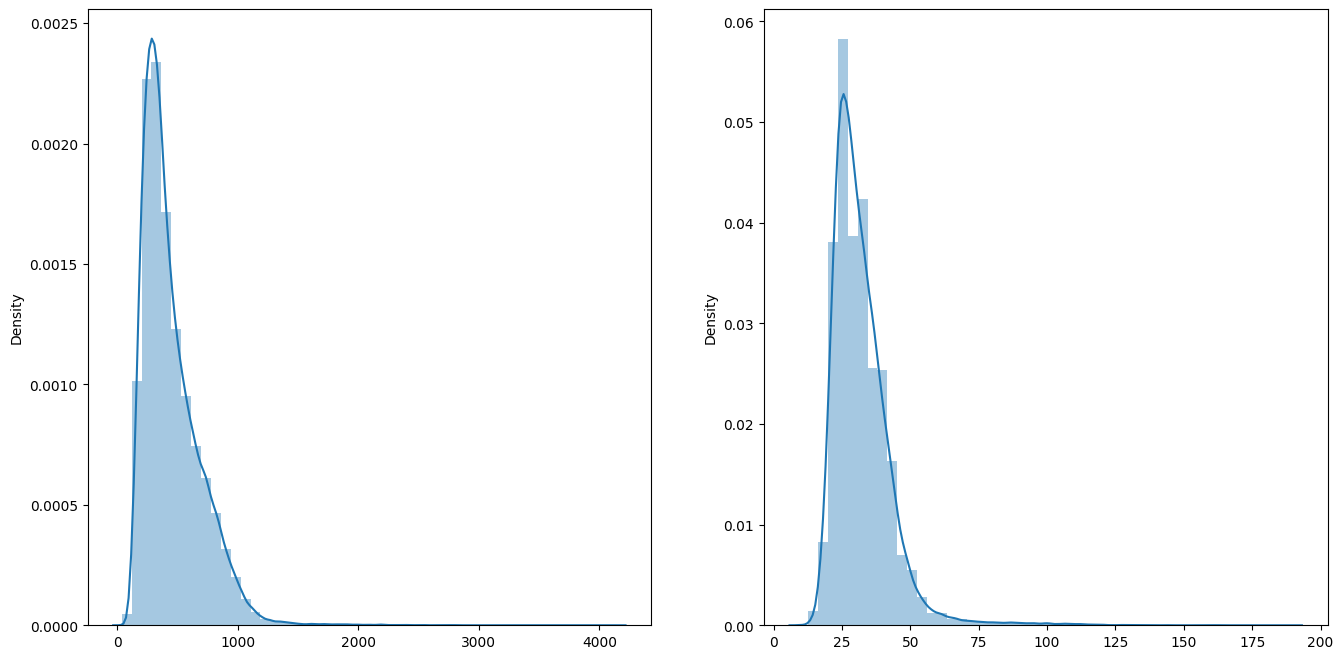

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
sns.distplot([len(hf_tokenizer(df['original'][i]).input_ids) for i in range(len(df))],ax=ax1)
sns.distplot([len(hf_tokenizer(df['summary'][i]).input_ids) for i in range(len(df))],ax=ax2)
# number tokens per sentence.


In [17]:
org_trunc = [len(hf_tokenizer(df['original'][i]).input_ids) for i in range(len(df))]
print(len([s for s in org_trunc if s > 1024])) # 2334 sentence has tokens > 1024

2338


In [18]:
org_trunc = [len(hf_tokenizer(df['original'][i]).input_ids) for i in range(len(df))]
print(len([s for s in org_trunc if s > 512])) # 2817 sentence has tokens > 512

33217


In [19]:
sry_trunc= [len(hf_tokenizer(df['summary'][i]).input_ids) for i in range(len(df))]
print(len([s for s in sry_trunc if s > 64])) # 1538 sentence has tokens > 64

1543


In [20]:
print(hf_tokenizer), print(hf_config), print(hf_model)


PhobertTokenizer(name_or_path='vinai/bartpho-word', vocab_size=64000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	64000: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
MBartConfig {
  "_name_or_path": "vinai/bartpho-word",
  "activati

(None, None, None)

In [21]:
tok_kwargs = {}
if (hf_arch == 'mbart'):
    tok_kwargs['src_lang'], tok_kwargs['tgt_lang'] = "Vi", "Vi"

In [22]:
before_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                  max_length=512, max_target_length=128,
                                                  tok_kwargs=tok_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=before_batch_tfm), noop)

dblock = DataBlock(blocks=blocks,
                   get_x=ColReader('original'),
                   get_y=ColReader('summary'),
                   splitter=ColSplitter('is_valid'))
# prepare data for train model.

In [23]:
dls = dblock.dataloaders(df, bs=8) # create dataloader

C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [24]:
dls.valid_ds[0]

('Cuộc_thi vừa kết_thúc tại tỉnh Ninh_Bình ngày 26-8 . Cuộc thi có 18 đội đến từ 17 nước và vùng lãnh_thổ tham_gia , trong đó nước chủ_nhà Việt_Nam có 2 đội là LH - ATM ( Việt Nam 1 ) và LH - Galaxy ( Việt Nam 2 ) đều đến từ Trường ĐH Lạc_Hồng ( tỉnh Đồng_Nai ) . Cuộc thi năm nay với chủ_đề " ném còn " , dựa trên trò_chơi dân_gian của đồng_bào dân_tộc vùng Tây_Bắc . Trong thời_gian tối_đa 3 phút , robot điều_khiển trao quả còn cho robot tự_động ném qua các vòng_tròn trên sân thi_đấu . Đội nào ném quả còn vàng qua vòng và đậu lên trên mâm còn vàng là giành chiến_thắng tuyệt_đối , gọi là " rồng bay " . Đây là lần thứ 7 , Việt Nam có đội vô_địch ở cuộc_thi ABU Robocon và Trường ĐH Lạc_Hồng đóng_góp 3 lần vào các năm 2013 , 2017 và năm nay . ABU Robocon 2019 sẽ được tổ_chức tại Mông_Cổ .  Các thành_viên đội LH - Galaxy vui_mừng sau khi giành ngôi vô_địch Robocon - Ảnh : QUANG_PHƯƠNG ',
 'Vượt qua đối_thủ nặng_ký Trung_Quốc , đội LH - Galaxy của Việt_Nam đã xuất_sắc giành ngôi vô_địch tạ

In [25]:
b = dls.one_batch() # pick one batch
len(b)

2

In [26]:
b[0]['token_type_ids'].shape

torch.Size([8, 512])

In [27]:
b[0]['labels'].shape

torch.Size([8, 106])

In [28]:
b[0]['input_ids'].shape

torch.Size([8, 512])

In [29]:
b[1].shape

torch.Size([8, 106])

In [30]:
dls.valid.show_batch(dataloaders=dls, max_n=2, input_trunc_at=300)

,text,target
0,"<s> Trường đại học Quốc_tế , đại học Quốc_gia TP. Hồ Chí Minh vừa công_bố điểm chuẩn kỳ thi đánh_giá năng_lực đại học Quốc_gia TP. Hồ Chí Minh năm 2019 . Theo đó , những ngành có điểm chuẩn cao nhất là 920 điểm và thấp nhất là 650 điểm . Thí_sinh trúng_tuyển phải nộp bản_chính giấy chứng_n","Các trường , khoa , viện trực_thuộc đại học Quốc_gia TP. Hồ Chí Minh đều đã công_bố điểm chuẩn trúng_tuyển phương_thức xét kết_quả thi đánh_giá năng_lực năm 2019 ."
1,"<s> Đồng_thời với việc bổ_sung các quy_định pháp_luật , cần phải có giải_pháp , cơ_chế để giám_sát được thời_gian làm_việc của các tài_xế . Đánh_giá , giám_sát được chất_lượng của việc khám sức_khoẻ định_kỳ cho tài_xế . Bà Nguyễn_Thị_Chúc_LinhNgoài những việc mà chủ xe , chủ doanh_nghiệp vận_tải có_","Từ những vụ tai_nạn giao_thông thảm_khốc , trong đó có nhiều vụ được xác_định lỗi do tài_xế như uống rượu_bia , sử_dụng ma_tuý ... , nhiều người cho_rằng cần đặt ra vấn_đề trách_nhiệm của chủ xe , doanh_nghiệp kinh_doanh vận_tải ."


In [31]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        }
    }


In [32]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls,
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()
# model

In [33]:
learn.freeze()

In [34]:
ob = dls.one_batch()
preds = learn.model(ob[0]) # predict on one batch

In [43]:
preds['loss'], preds['logits'].shape, preds['encoder_last_hidden_state'].shape

(tensor(5.3414, device='cuda:0', grad_fn=<NllLossBackward0>),
 torch.Size([8, 43, 64001]),
 torch.Size([8, 512, 1024]))

In [44]:
print(len(learn.opt.param_groups))

3


C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locati

SuggestedLRs(minimum=0.0002511886414140463, steep=2.511886486900039e-05, valley=4.365158383734524e-05, slide=0.0030199517495930195)

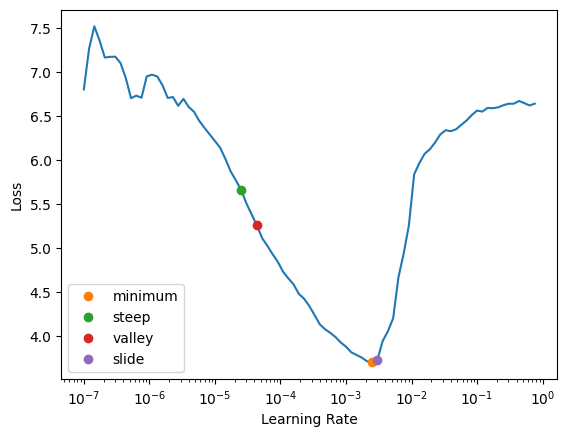

In [45]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide]) # find learning rate

In [46]:
learn.fit_one_cycle(3, lr_max=1e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,1.627032,1.524493,0.521937,0.245442,0.356373,1:28:42
1,1.333687,1.393968,0.536871,0.263624,0.371409,1:05:12
2,1.070207,1.395703,0.537844,0.264025,0.371723,1:17:29


In [63]:
import blurr.modeling.seq2seq.core
print(blurr.modeling.seq2seq.core.__file__)


C:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\blurr\modeling\seq2seq\core.py


In [47]:
learn.show_results(learner=learn, input_trunc_at=256, max_n=2)

,text,target,prediction
0,"Trường đại học Quốc_tế , đại học Quốc_gia TP. Hồ Chí Minh vừa công_bố điểm chuẩn kỳ thi đánh_giá năng_lực đại học Quốc_gia TP. Hồ Chí Minh năm 2019 . Theo đó , những ngành có điểm chuẩn cao nhất là 920 điểm và thấp nhất là 650 điểm . Thí_sinh trú","Các trường , khoa , viện trực_thuộc đại học Quốc_gia TP. Hồ Chí Minh đều đã công_bố điểm chuẩn trúng_tuyển phương_thức xét kết_quả thi đánh_giá năng_lực năm 2019 .","Trường đại học Quốc_tế , đại học Quố@@"
1,"Theo kết_luận thanh_tra ( KLTT ) vừa được Thanh_tra Chính_phủ ( TTCP ) ban_hành , đến nay dự_án mở_rộng sản_xuất giai_đoạn 2 Công_ty Gang_thép Thái_Nguyên ( TISCO ) được đầu_tư tổng_số tiền đã thanh_toán hơn 4.400 tỉ đồng và tổng dư_nợ gốc , lãi vay ngân_h",Một trong những sai_phạm nghiêm_trọng tại dự_án mở_rộng giai_đoạn 2 Nhà_máy Gang_thép Thái_Nguyên được Thanh_tra Chính_phủ chỉ ra là nhiều loại thiết_bị được nhập với trị_giá hàng triệu USD nhưng sai chủng_loại .,"Dự_án mở_rộng sản_xuất giai_đoạn 2 Công_ty Gang_thép Thái_Nguyên được đầu_tư hơn 4.400 tỉ đồng , đã thanh_toán hơn"


# INFERENCE

In [64]:
test_df['original'][1]

'Trùm sòng bạc Trung_Quốc Jack_Lam . Các cảnh_sát mở cuộc truy_nã trên toàn_quốc để bắt ông Lam , theo lệnh trực_tiếp của Tổng_thống Rodrigo_Duterte , với cáo_buộc hối_lộ và " phá_hoại nền kinh_tế " , Rappler dẫn lời lãnh_đạo Cảnh_sát Quốc_gia Philippines_Ronald dela Rosa hôm 3/12 cho biết . Một ngày sau , Cục Nhập_cư phát thông_cáo , cho_biết Lam_Yin_Yok ( được cho là tên thật của ông Lam ) rời Philippines hôm 29/11 trên chuyến bay Cathay_Pacific tới Hong_Kong . Luật_sư của ông Lam chưa bình_luận công_khai về cáo_buộc cũng như nơi ở hiện_tại của ông . Lam bị_cáo buộc âm_mưu hối_lộ Bộ_trưởng Tư_pháp Vitaliano_Aguirre cũng như Andrea_Domingo , Chủ_tịch tập_đoàn Trò_chơi Giải_trí ( Pagcor ) , sau khi cảnh_sát lục_soát sòng bài Fontana của ông Lam ở vùng Clark , tỉnh Pampanga . Tại đây hôm 24/11 , họ bắt hơn 1.300 công_dân Trung_Quốc làm_việc bất_hợp_pháp . Ông Aguirre hôm 26/11 gặp ông Lam ở thành_phố thành_phố Taguig , trực_thuộc vùng đô_thị Manila , sau khi các công_dân Trung_Quốc bị b

In [66]:
outputs = learn.blurr_generate(test_df['original'][1])

print(f'=== Prediction ===\n{outputs[0]}\n')

=== Prediction ===
Cảnh_sát Philippines hôm_nay phát lệnh truy_nã trên toàn_quốc với ông Jack_Lam , trùm sòng bạc lớn



# SAVE MODEL

In [57]:
from huggingface_hub import notebook_login
notebook_login()

In [53]:
!sudo apt-get install git-lfs -qq

'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [58]:
!git config --global user.email "vipboy20031408@gmail.com"
!git config --global user.name "creamyngreen"

In [59]:
from blurr.data.core import get_blurr_tfm
blurr_tfm = get_blurr_tfm(learn.dls.before_batch)     

In [60]:
blurr_tfm.hf_model.push_to_hub("vietnamese-summarization",use_temp_dir=True)

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/creamyngreen/vietnamese-summarization/commit/20a94a2911d334cf926a22a2b8adba704723854d', commit_message='Upload MBartForConditionalGeneration', commit_description='', oid='20a94a2911d334cf926a22a2b8adba704723854d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/creamyngreen/vietnamese-summarization', endpoint='https://huggingface.co', repo_type='model', repo_id='creamyngreen/vietnamese-summarization'), pr_revision=None, pr_num=None)

In [67]:
blurr_tfm.hf_tokenizer.push_to_hub("vietnamese-summarization",use_temp_dir=True)  

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/creamyngreen/vietnamese-summarization/commit/4379416e0ad13295e7aed9db0a29b98e8f1fcb30', commit_message='Upload tokenizer', commit_description='', oid='4379416e0ad13295e7aed9db0a29b98e8f1fcb30', pr_url=None, repo_url=RepoUrl('https://huggingface.co/creamyngreen/vietnamese-summarization', endpoint='https://huggingface.co', repo_type='model', repo_id='creamyngreen/vietnamese-summarization'), pr_revision=None, pr_num=None)